# Making a connectivity matrix from the Fruit Fly connectome

Using Janelia's data [here](https://storage.cloud.google.com/hemibrain/v1.2/exported-traced-adjacencies-v1.2.tar.gz) (explained [here](https://dvid.io/blog/release-v1.2/#downloads))

We get a list of all neuron names, types and ids, and then a list of the number of synapses from one neuron to another.

We can use these to make a connectivity matrix (based on the number of synapses) for the neurons in the central complex circuit (PEN, PEG, EPG, Delta7)

In [1]:
import pandas as pd
import numpy as np
import numpy.lib.stride_tricks
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [10,6]) # paper figures should be width 10 (full linewidth) to have nicely readable text

Load all the neurons and connections in the dataset

In [2]:
neurons = pd.read_csv('janelia-data/traced-neurons.csv')
connections = pd.read_csv('janelia-data/traced-total-connections.csv')
neurons

,bodyId,type,instance
0,200326126,CL141,CL141_L
1,202916528,FS4C,FS4C(FQ12)_C4_R
2,203253072,FS4A,FS4A(AB)(FQ12)_C3_R
3,203253253,SMP505,SMP505(PDM22)_L
4,203257652,FS4C,FS4C(FQ12)_C6_R
...,...,...,...
21734,7112579856,LC20,LC20
21735,7112615127,AVLP335,AVLP335_R
21736,7112617294,AVLP331,AVLP331_R
21737,7112622044,LAL137,LAL137(PVL05)_L


We are interested in EPG, PEG, PEN and Delta7 neurons. By searching through the list of neurons we identify the corresponding types.

There are actually 2 types of PEN neurons in the dataset (PEN1 and PEN2), but we group these together.

We sort them by instance (basically which glomerulus they're in) for plotting later

In [3]:
# group PEN1 and PEN2, and EPG and EPGt
pen = pd.concat((neurons[neurons.type == 'PEN_a(PEN1)'], neurons[neurons.type == 'PEN_b(PEN2)']))
pen = pen.loc[pen.instance.apply(lambda x: x[-2:]).sort_values().index] # sort by the last two characters of the instance (eg. L1, R4, ...)
peg = neurons[neurons.type == 'PEG'].sort_values('instance')
epg = pd.concat((neurons[neurons.type == 'EPG'], neurons[neurons.type == 'EPGt']))
epg = epg.loc[epg.instance.apply(lambda x: x[-2:]).sort_values().index] # sort by the last two characters of the instance (eg. L1, R4, ...)
d7 = neurons[neurons.type == 'Delta7'].sort_values('instance')

# flip the sorting of neurons on right side so the order becomes (ie. L1, L2, ..., L9, R9, ..., R2, R1)
pen = pen.sort_values(by='instance', key=lambda column: column.apply(lambda instance: int(instance[-1]) if instance[-2] == 'L' else 100-int(instance[-1])))
peg = peg.sort_values(by='instance', key=lambda column: column.apply(lambda instance: int(instance[-1]) if instance[-2] == 'L' else 100-int(instance[-1])))
epg = epg.sort_values(by='instance', key=lambda column: column.apply(lambda instance: int(instance[-1]) if instance[-2] == 'L' else 100-int(instance[-1])))

ids = list(pd.concat((pen.bodyId, peg.bodyId, epg.bodyId, d7.bodyId)))
ids_set = set(ids) # faster to call `in` for a set

Get the rows of the connections table that we care about - those for which the pre and post synaptic neuron are ones we care about

In [4]:
connections_subset = connections.iloc[[pre_id in ids_set and post_id in ids_set for pre_id, post_id in zip(connections.bodyId_pre, connections.bodyId_post)]]
connections_subset

,bodyId_pre,bodyId_post,weight
229804,387364605,789126240,1
229810,387364605,1065409934,1
229813,387364605,912545106,3
229815,387364605,1035045015,1
229818,387364605,911565419,1
...,...,...,...
3459269,5813080838,5813056953,25
3459273,5813080838,1220576923,8
3459275,5813080838,973566036,43
3459277,5813080838,911578496,35


Now convert this list of connections (pre,post,weight) to a connectivity matrix

In [5]:
connectivity_matrix = np.zeros((len(ids),len(ids)))

for pre_id, post_id, weight in connections_subset.itertuples(index=False):
	connectivity_matrix[ids.index(pre_id), ids.index(post_id)] = weight

np.save('connectivity_matrix_drosophila_janelia', connectivity_matrix)

In [6]:
print(f'In total we have {int(connectivity_matrix.sum())} synapses between the {connectivity_matrix.shape[0]} neurons')

In total we have 129473 synapses between the 152 neurons


Plot the connectivity matrix with annotations of the regions with different neurons types

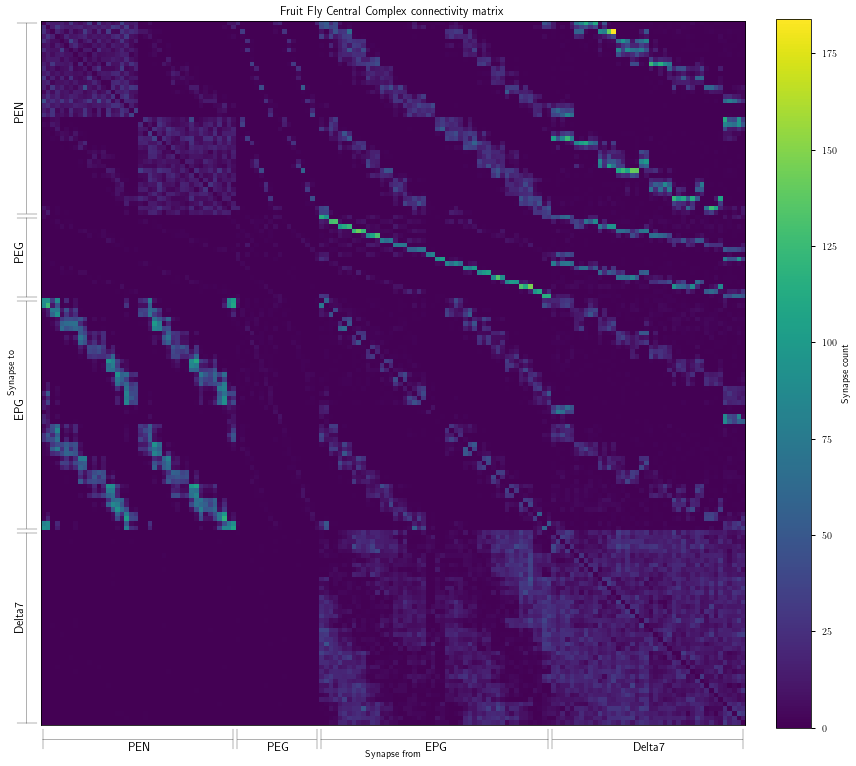

In [7]:
plt.figure(figsize=(12,12))
im = plt.imshow(connectivity_matrix.T)
plt.xlabel('\n\nSynapse from')
plt.ylabel('Synapse to\n\n')
plt.title('Fruit Fly Central Complex connectivity matrix')
plt.xticks([])
plt.yticks([])

type_borders = np.cumsum([0,len(pen),len(peg),len(epg),len(d7)])

for start,stop,type in zip(type_borders[:-1], type_borders[1:],['PEN','PEG','EPG','Delta7']):
	bar_distance = 3
	plt.annotate('',xy=(start-.5,plt.ylim()[0]+bar_distance),xytext=(stop-.5,plt.ylim()[0]+bar_distance), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)
	plt.annotate('',xy=(plt.xlim()[0]-bar_distance,start-.5),xytext=(plt.xlim()[0]-bar_distance,stop-.5), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)

	plt.annotate(type,xy=((start+stop)/2,plt.ylim()[0]+bar_distance+2.5), annotation_clip=False, fontsize=12, horizontalalignment='center')
	plt.annotate(type,xy=(plt.xlim()[0]-bar_distance-1.5,(start+stop)/2), annotation_clip=False, fontsize=12, horizontalalignment='center', rotation=90)

plt.colorbar(im, fraction=0.046, pad=0.04, label='Synapse count')
plt.tight_layout()
plt.savefig('plots/janelia-connectivity-matrix-full.pdf')
plt.show()

## Group neurons in the same glomerulus

Looking for example at the EPG neurons (instance column), we can see that there are multiple neurons in each of the glomeruli (L1, R4, ...).

We can group these to simplify the connectivity matrix, assuming the same type of neurons in the same glomerulus perform a similar function.

In [8]:
epg

,bodyId,type,instance
13392,1447576662,EPG,EPG(PB08)_L1
3381,572870540,EPG,EPG(PB08)_L1
7423,912545106,EPG,EPG(PB08)_L2
4907,697001770,EPG,EPG(PB08)_L2
5615,758419409,EPG,EPG(PB08)_L3
1277,387364605,EPG,EPG(PB08)_L3
1935,449438847,EPG,EPG(PB08)_L3
4172,634962055,EPG,EPG(PB08)_L4
4512,665314820,EPG,EPG(PB08)_L4
19562,5813022281,EPG,EPG(PB08)_L4


The same is true for the PEN neurons

In [9]:
pen

,bodyId,type,instance
20190,5813047157,PEN_b(PEN2),PEN_b(PB06b)_L2
4160,634608104,PEN_a(PEN1),PEN_a(PB06a)_L2
20985,5813070465,PEN_b(PEN2),PEN_b(PB06b)_L3
13950,1508334312,PEN_a(PEN1),PEN_a(PB06a)_L3
2908,539462336,PEN_b(PEN2),PEN_b(PB06b)_L4
6541,849482511,PEN_a(PEN1),PEN_a(PB06a)_L4
1270,387023620,PEN_b(PEN2),PEN_b(PB06b)_L4
5586,757055317,PEN_a(PEN1),PEN_a(PB06a)_L4
21179,5813080979,PEN_a(PEN1),PEN_a(PB06a)_L5
14856,1631450739,PEN_b(PEN2),PEN_b(PB06b)_L5


For Delta7 neurons it isn't so clear because they have both a left and right glomerulus. In general the left and right glomerulus numbers sum to 9, but this isn't always the case.

We decide just to assign Delta7 neurons based on the left glomerulus.

In [10]:
d7

,bodyId,type,instance
20727,5813061383,Delta7,Delta7(PB15)_L1L9R8_R
7402,911919917,Delta7,Delta7(PB15)_L1L9R8_R
6937,881221166,Delta7,Delta7(PB15)_L1L9R8_R
7396,911911004,Delta7,Delta7(PB15)_L1L9R8_R
7381,911574261,Delta7,Delta7(PB15)_L1L9R8_R
7820,942522378,Delta7,Delta7(PB15)_L2R7_R
7398,911911699,Delta7,Delta7(PB15)_L2R7_R
7384,911578496,Delta7,Delta7(PB15)_L2R7_R
7380,911574041,Delta7,Delta7(PB15)_L2R7_R
7370,911470352,Delta7,Delta7(PB15)_L2R7_R


Create a list of the index of the group to which each neuron belongs

In [11]:
# create groups based on the unique instances of each type of neuron, preserving the ordering we used above
# format these in a predictable way like PEN_L2 and D7_R4
all_neuron_instances = pd.concat((
	pen.instance.apply(lambda x: f'PEN_{x[-2:]}'),
	peg.instance.apply(lambda x: f'PEG_{x[-2:]}'),
	epg.instance.apply(lambda x: f'EPG_{x[-2:]}'),
	d7.instance.apply(lambda x: f'D7_{x.split("_")[1][:2]}') # note: D7 mixes some slightly different neurons eg. L4R5 and L4R6... - group by the left glomerulus
))

# create a list of the index of the unique neuron type + glomerulus group to which each individual neuron belongs so we can do the grouping - `neuron_group_indices`
neuron_groups, unique_indices = np.unique(all_neuron_instances, return_index=True)
neuron_groups = list(neuron_groups[np.argsort(unique_indices)])
neuron_group_indices = np.array([neuron_groups.index(instance) for instance in all_neuron_instances])

We can check how many neurons were assigned to each group. It isn't evenly distributed, but there aren't any extremely significant outliers

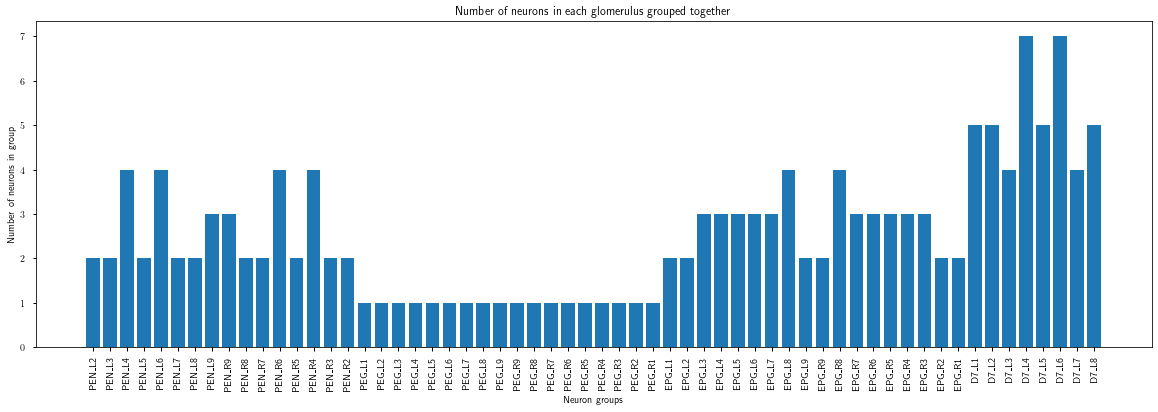

In [12]:
plt.figure(figsize=(20,6))
_, neuron_group_counts = np.unique(neuron_group_indices, return_counts=True)
plt.bar(neuron_groups, neuron_group_counts)
plt.xticks(rotation=90)
plt.ylabel('Number of neurons in group')
plt.xlabel('Neuron groups')
plt.title('Number of neurons in each glomerulus grouped together')
plt.show()

We now create a new connectivity matrix with one cell for each group by summing the synapse counts for all neurons in the group.

In [13]:
connectivity_matrix_grouped = np.zeros((len(neuron_groups), len(neuron_groups)))

for pre_id, post_id, weight in connections_subset.itertuples(index=False):
	connectivity_matrix_grouped[neuron_group_indices[ids.index(pre_id)], neuron_group_indices[ids.index(post_id)]] += weight

np.save('connectivity_matrix_drosophila_janelia_grouped', connectivity_matrix_grouped)

In [14]:
print(f'In total we have {int(connectivity_matrix_grouped.sum())} synapses between the {connectivity_matrix_grouped.shape[0]} neurons')

In total we have 129473 synapses between the 60 neurons


We then visualise the grouped connectivity matrix, which is similar in form to those in Pisokas, 2020.

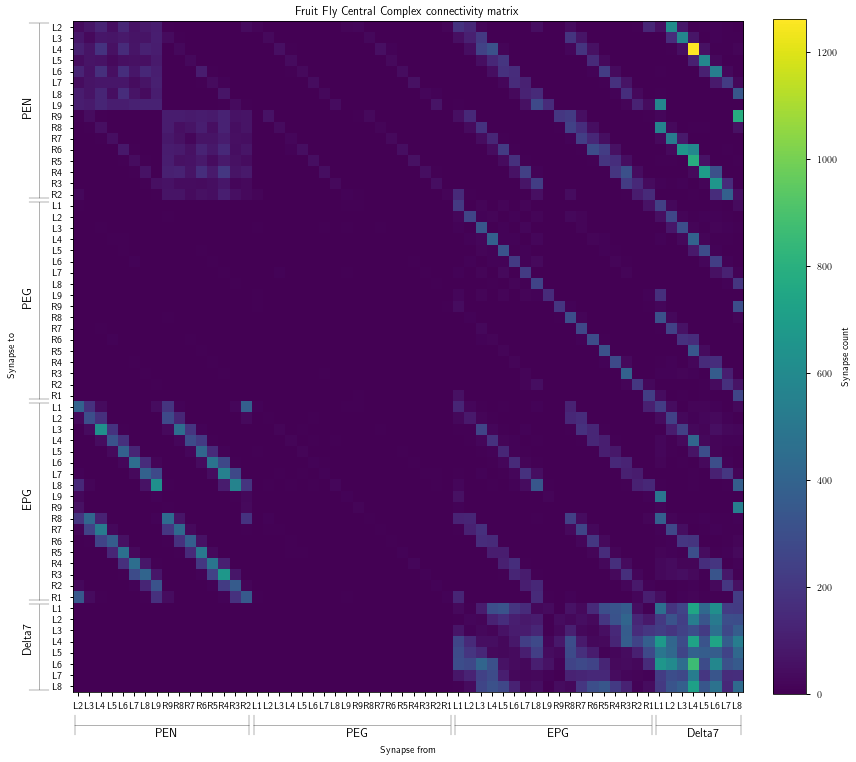

In [15]:
plt.figure(figsize=(12,12))
im = plt.imshow(connectivity_matrix_grouped.T)
plt.xlabel('\n\n\nSynapse from')
plt.ylabel('Synapse to\n\n\n')
plt.title('Fruit Fly Central Complex connectivity matrix')
plt.xticks(np.arange(len(neuron_groups)), [s.split('_')[1] for s in neuron_groups])
plt.yticks(np.arange(len(neuron_groups)), [s.split('_')[1] for s in neuron_groups])

num_neuron_groups_by_type = lambda type: len([neuron for neuron in neuron_groups if neuron.startswith(type)])
type_borders = np.cumsum([0]+[num_neuron_groups_by_type(t) for t in ['PEN','PEG','EPG','D7']])

for start,stop,type in zip(type_borders[:-1], type_borders[1:],['PEN','PEG','EPG','Delta7']):
	bar_distance = 3
	plt.annotate('',xy=(start-.5,plt.ylim()[0]+bar_distance),xytext=(stop-.5,plt.ylim()[0]+bar_distance), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)
	plt.annotate('',xy=(plt.xlim()[0]-bar_distance,start-.5),xytext=(plt.xlim()[0]-bar_distance,stop-.5), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)

	plt.annotate(type,xy=((start+stop)/2,plt.ylim()[0]+bar_distance+1), annotation_clip=False, fontsize=12, horizontalalignment='center')
	plt.annotate(type,xy=(plt.xlim()[0]-bar_distance-1,(start+stop)/2), annotation_clip=False, fontsize=12, horizontalalignment='center', rotation=90)

plt.colorbar(im, fraction=0.046, pad=0.04, label='Synapse count')
plt.tight_layout()
plt.savefig('plots/janelia-connectivity-matrix-grouped.pdf')
plt.show()

## Group both hemispheres together

Now we group the neurons in the corresponding glomeruli across the left and right hemispheres together to produce a network with 8 EPG neurons, comparable to our theoretical networks.

In [16]:
# create groups based on the unique instances of each type of neuron, preserving the ordering we used above
# format these in a predictable way like PEN_2 and D7_4
all_neuron_instances = pd.concat((
	pen.instance.apply(lambda x: f'PEN_{x[-1:]}'),
	peg.instance.apply(lambda x: f'PEG_{x[-1:]}'),
	epg.instance.apply(lambda x: f'EPG_{x[-1:]}'),
	d7.instance.apply(lambda x: f'D7_{x.split("_")[1][1:2]}')
))
# create a list of the index of the unique neuron type + glomerulus group to which each individual neuron belongs so we can do the grouping - `neuron_group_indices`
neuron_groups, unique_indices = np.unique(all_neuron_instances, return_index=True)
neuron_groups = list(neuron_groups[np.argsort(unique_indices)])
neuron_group_indices = np.array([neuron_groups.index(instance) for instance in all_neuron_instances])

In [17]:
# create the one sided connectivity_matrix
connectivity_matrix_one_sided = np.zeros((len(neuron_groups), len(neuron_groups)))
neuron_connection_count = np.zeros((len(neuron_groups), len(neuron_groups)))

for pre_id, post_id, weight in connections_subset.itertuples(index=False):
	connectivity_matrix_one_sided[neuron_group_indices[ids.index(pre_id)], neuron_group_indices[ids.index(post_id)]] += weight
	neuron_connection_count[neuron_group_indices[ids.index(pre_id)], neuron_group_indices[ids.index(post_id)]] += 1

np.save('connectivity_matrix_drosophila_janelia_one_sided', connectivity_matrix_one_sided)

In [18]:
print(f'In total we have {int(connectivity_matrix_one_sided.sum())} synapses between the {connectivity_matrix_one_sided.shape[0]} neurons')

In total we have 129473 synapses between the 34 neurons


Visualise the one sided network connectivity matrix

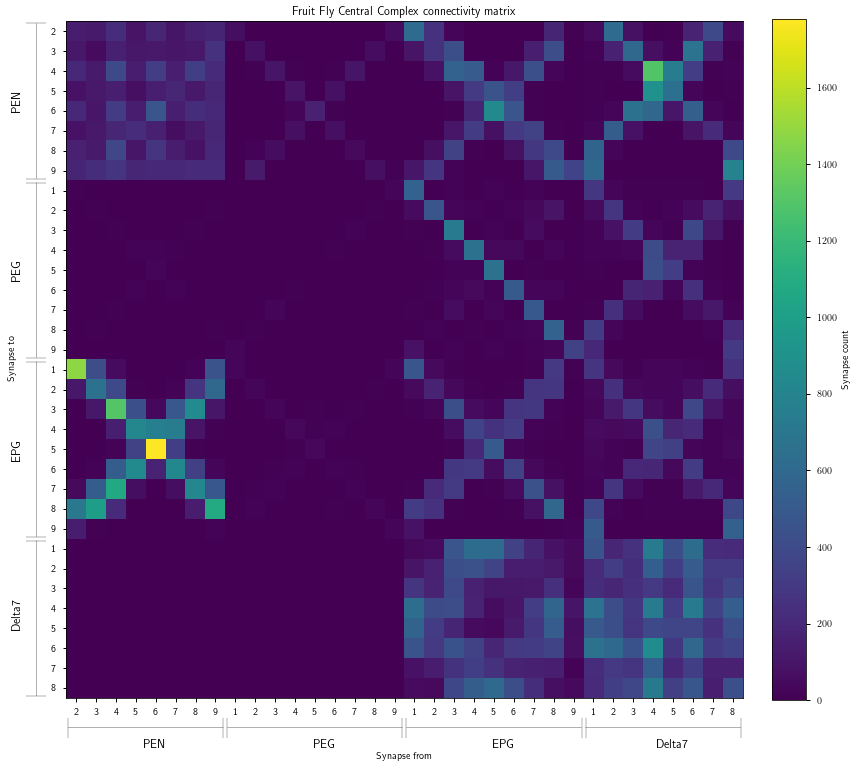

In [19]:
plt.figure(figsize=(12,12))
im = plt.imshow(connectivity_matrix_one_sided.T)
plt.xlabel('\n\n\nSynapse from')
plt.ylabel('Synapse to\n\n\n')
plt.title('Fruit Fly Central Complex connectivity matrix')
plt.xticks(np.arange(len(neuron_groups)), [s.split('_')[1] for s in neuron_groups])
plt.yticks(np.arange(len(neuron_groups)), [s.split('_')[1] for s in neuron_groups])

num_neuron_groups_by_type = lambda type: len([neuron for neuron in neuron_groups if neuron.startswith(type)])
type_borders = np.cumsum([0]+[num_neuron_groups_by_type(t) for t in ['PEN','PEG','EPG','D7']])

for start,stop,type in zip(type_borders[:-1], type_borders[1:],['PEN','PEG','EPG','Delta7']):
	bar_distance = 1.5
	plt.annotate('',xy=(start-.5,plt.ylim()[0]+bar_distance),xytext=(stop-.5,plt.ylim()[0]+bar_distance), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)
	plt.annotate('',xy=(plt.xlim()[0]-bar_distance,start-.5),xytext=(plt.xlim()[0]-bar_distance,stop-.5), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)

	plt.annotate(type,xy=((start+stop)/2,plt.ylim()[0]+bar_distance+1), annotation_clip=False, fontsize=12, horizontalalignment='center')
	plt.annotate(type,xy=(plt.xlim()[0]-bar_distance-1,(start+stop)/2), annotation_clip=False, fontsize=12, horizontalalignment='center', rotation=90)

plt.colorbar(im, fraction=0.046, pad=0.04, label='Synapse count')
plt.tight_layout()
plt.savefig('plots/janelia-connectivity-matrix-grouped-one-side.pdf')
plt.show()

## Grouping EPG9 and EPG1, and PEG9 and PEG1

In Pisokas, 2020 the PEG9 neuron is grouped with the PEG1 because they both send their outputs to the same segment of the ellipsoid body, and EPG9 is grouped with EPG1 because they receive common inputs. This results in a network with 8 EPG neurons, comparable to the theory.

In [20]:
# create groups based on the unique instances of each type of neuron, preserving the ordering we used above
# format these in a predictable way like PEN_2 and D7_4
all_neuron_instances = pd.concat((
	pen.instance.apply(lambda x: f'PEN_{x[-1:]}'),
	peg.instance.apply(lambda x: f'PEG_{x[-1:]}'),
	epg.instance.apply(lambda x: f'EPG_{x[-1:]}'),
	d7.instance.apply(lambda x: f'D7_{x.split("_")[1][1:2]}')
))
all_neuron_instances[all_neuron_instances == 'EPG_9'] = 'EPG_1'
all_neuron_instances[all_neuron_instances == 'PEG_9'] = 'PEG_1'
# create a list of the index of the unique neuron type + glomerulus group to which each individual neuron belongs so we can do the grouping - `neuron_group_indices`
neuron_groups, unique_indices = np.unique(all_neuron_instances, return_index=True)
neuron_groups = list(neuron_groups[np.argsort(unique_indices)])
neuron_group_indices = np.array([neuron_groups.index(instance) for instance in all_neuron_instances])

In [21]:
# create the one sided connectivity_matrix
connectivity_matrix_one_sided_8_neurons = np.zeros((len(neuron_groups), len(neuron_groups)))
neuron_connection_count = np.zeros((len(neuron_groups), len(neuron_groups)))

for pre_id, post_id, weight in connections_subset.itertuples(index=False):
	connectivity_matrix_one_sided_8_neurons[neuron_group_indices[ids.index(pre_id)], neuron_group_indices[ids.index(post_id)]] += weight
	neuron_connection_count[neuron_group_indices[ids.index(pre_id)], neuron_group_indices[ids.index(post_id)]] += 1

np.save('connectivity_matrix_drosophila_janelia_one_sided_8_neurons', connectivity_matrix_one_sided_8_neurons)

In [22]:
print(f'In total we have {int(connectivity_matrix_one_sided_8_neurons.sum())} synapses between the {connectivity_matrix_one_sided_8_neurons.shape[0]} neurons')

In total we have 129473 synapses between the 32 neurons


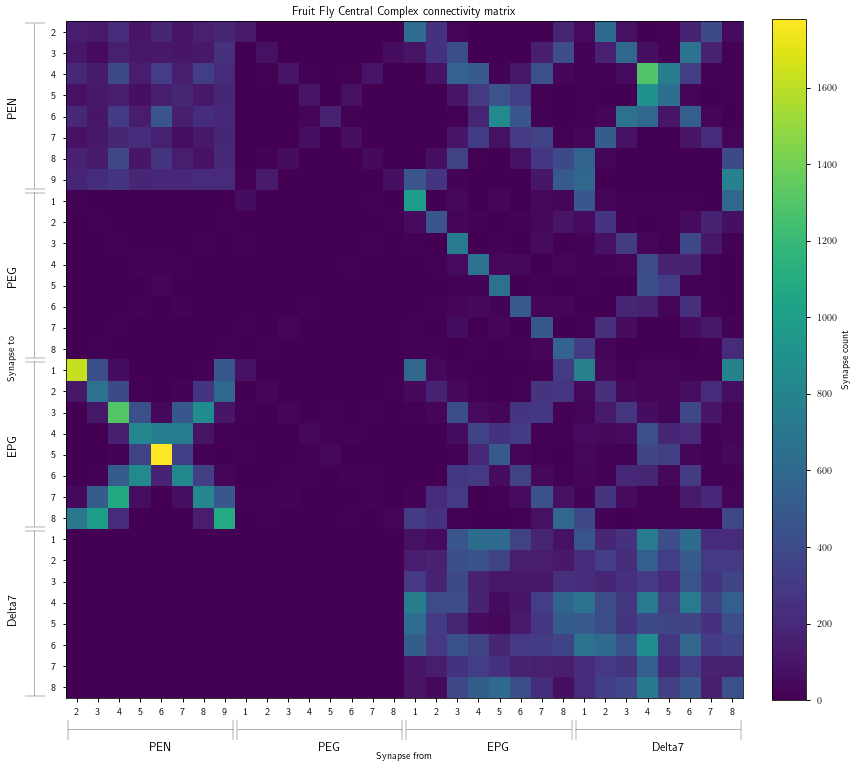

In [23]:
plt.figure(figsize=(12,12))
im = plt.imshow(connectivity_matrix_one_sided_8_neurons.T)
plt.xlabel('\n\n\nSynapse from')
plt.ylabel('Synapse to\n\n\n')
plt.title('Fruit Fly Central Complex connectivity matrix')
plt.xticks(np.arange(len(neuron_groups)), [s.split('_')[1] for s in neuron_groups])
plt.yticks(np.arange(len(neuron_groups)), [s.split('_')[1] for s in neuron_groups])

num_neuron_groups_by_type = lambda type: len([neuron for neuron in neuron_groups if neuron.startswith(type)])
type_borders = np.cumsum([0]+[num_neuron_groups_by_type(t) for t in ['PEN','PEG','EPG','D7']])

for start,stop,type in zip(type_borders[:-1], type_borders[1:],['PEN','PEG','EPG','Delta7']):
	bar_distance = 1.5
	plt.annotate('',xy=(start-.5,plt.ylim()[0]+bar_distance),xytext=(stop-.5,plt.ylim()[0]+bar_distance), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)
	plt.annotate('',xy=(plt.xlim()[0]-bar_distance,start-.5),xytext=(plt.xlim()[0]-bar_distance,stop-.5), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)

	plt.annotate(type,xy=((start+stop)/2,plt.ylim()[0]+bar_distance+1), annotation_clip=False, fontsize=12, horizontalalignment='center')
	plt.annotate(type,xy=(plt.xlim()[0]-bar_distance-1,(start+stop)/2), annotation_clip=False, fontsize=12, horizontalalignment='center', rotation=90)

plt.colorbar(im, fraction=0.046, pad=0.04, label='Synapse count')
plt.tight_layout()
plt.savefig('plots/janelia-connectivity-matrix-grouped-one-side-8-neurons.pdf')
plt.show()